In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg

## load Vancouver data

In [2]:
train = pd.read_csv('Vancouver_climate.csv')
train['doy'] = pd.to_datetime(train['DATE']).dt.dayofyear
train['year'] = pd.to_datetime(train['DATE']).dt.year
train['CDD'] = (train.groupby(['year']))['TAVG'].cumsum()
print(train.shape)
train.head()

(31088, 9)


,DATE,TMAX,TAVG,TMIN,PRCP,SNDW,doy,year,CDD
0,1937-01-01,3.9,-1.09,-6.1,0.0,0.0,1,1937,-1.09
1,1937-01-02,0.0,-2.80,-5.6,0.0,0.0,2,1937,-3.89
2,1937-01-03,6.1,2.19,-1.7,0.0,0.0,3,1937,-1.70
3,1937-01-04,5.0,0.29,-4.4,0.0,0.0,4,1937,-1.41
4,1937-01-05,-1.1,-6.10,-11.1,0.0,0.0,5,1937,-7.51


In [3]:
train.describe()

,TMAX,TAVG,TMIN,PRCP,SNDW,doy,year,CDD
count,31083.000000,31081.000000,31085.000000,31030.000000,30965.000000,31088.000000,31088.000000,31081.000000
mean,13.782836,10.109838,6.439099,3.100139,0.119464,182.905430,1979.058769,1737.857872
std,6.431696,5.823728,5.540936,6.334746,1.128999,105.536291,24.570124,1316.489141
min,-11.100000,-14.450000,-17.800000,0.000000,0.000000,1.000000,1937.000000,-219.460000
25%,8.900000,5.850000,2.600000,0.000000,0.000000,91.000000,1958.000000,434.180000
50%,13.300000,9.900000,6.700000,0.000000,0.000000,183.000000,1979.000000,1574.300000
75%,19.000000,15.000000,11.100000,3.400000,0.000000,274.000000,2000.000000,3063.020000
max,34.400000,28.400000,22.400000,91.600000,41.000000,366.000000,2022.000000,4200.780000


## $\log{\frac{P_t}{1-P_t}} = \beta_0 + \beta_1 t + \beta_2 \text{CDD}_t$

## $\text{CDD}_t = \sum_{i=1}^{t}T $

## Validation 2001 - 2000

In [4]:
beta0_before = np.array([-280.08748249, -250.17648572, -310.13513578, -176.82744787,
       -152.95793016, -167.04313605, -326.51569084, -175.52126718,
       -106.76351411, -234.71521583, -169.4254379 , -198.79201096,
       -259.92757024, -465.71192393, -261.31640609, -353.64453504,
       -333.92239345, -231.05418157, -199.98655687, -230.93356069,
       -262.02752348, -163.02338885, -222.47279548, -161.09562497,
       -233.60293469, -153.58760558, -113.63787838, -272.85464508,
       -228.77625924, -239.83357604, -197.43552975, -121.38247144,
       -173.53608265, -192.47507819, -217.16998023, -231.93332415,
       -431.75072467, -278.25212287, -308.91322631, -287.4463173 ,
       -168.92908464, -169.39543163, -188.19669916, -239.89359091,
       -207.06346815, -267.23371307, -293.30355958, -198.60158523,
       -228.91742371, -167.07238986, -159.21349872, -144.49851427,
       -151.1508533 , -208.6450107 , -291.56565046, -252.91688135,
       -244.94548695, -146.73587405, -288.09404693, -154.60313102,
       -259.34866855, -214.30064519, -287.26420128, -288.00558743])

In [5]:
beta1_before = np.array([0.02139364, 0.06404033, 0.08119051, 0.37827502, 0.03000518,
       0.02498499, 0.12014821, 0.0217338 , 0.01521451, 0.04663866,
       0.01677527, 0.12910024, 0.02800224, 0.14951081, 0.03917352,
       0.06390864, 0.07572465, 0.03422127, 0.03114359, 0.03749153,
       0.04559813, 0.02300848, 0.0350506 , 0.0160891 , 0.09816575,
       0.02252608, 0.0167999 , 0.04672933, 0.05489754, 0.0772518 ,
       0.02189389, 0.02225172, 0.02270278, 0.04065857, 0.06383378,
       0.03018785, 0.10687923, 0.02766626, 0.05366038, 0.06512762,
       0.07715743, 0.02583628, 0.04379344, 0.03711989, 0.02107793,
       0.45741101, 0.04232079, 0.04006166, 0.04830874, 0.02198095,
       0.02801757, 0.02768643, 0.01493843, 0.01774814, 0.04473892,
       0.03355311, 0.04623558, 0.03495746, 0.06901879, 0.03111685,
       0.04402535, 0.02123088, 0.0445145 , 0.09211035])

In [6]:
beta2_before = np.array([0.40403062, 0.58299776, 0.62507945, 0.66675549, 0.45593778,
       0.42724534, 0.69059681, 0.40622953, 0.35604983, 0.5297237 ,
       0.36918734, 0.69747772, 0.44493766, 0.70862941, 0.49979502,
       0.58474438, 0.61432102, 0.46489963, 0.46169742, 0.49235115,
       0.52566724, 0.41478735, 0.48121849, 0.36351011, 0.65728334,
       0.41175417, 0.3694621 , 0.52940515, 0.55722742, 0.61711219,
       0.40696778, 0.4098017 , 0.41283785, 0.50582225, 0.58341285,
       0.45608665, 0.67487418, 0.44308824, 0.55309286, 0.58677053,
       0.61865413, 0.43236362, 0.51816354, 0.49045876, 0.40176665,
       0.66705319, 0.51256616, 0.50356059, 0.53531913, 0.40803495,
       0.44511575, 0.44322749, 0.35368665, 0.37707167, 0.52065426,
       0.47414489, 0.52739045, 0.48077085, 0.59743901, 0.46182252,
       0.51966695, 0.40291494, 0.52085465, 0.63955025])

In [7]:
seattle_doy = np.array([77, 68, 67, 86, 85, 87, 84, 92])
seattle_year = np.arange(2014, 2021 + 1)
print(seattle_doy)
print(seattle_year)

[77 68 67 86 85 87 84 92]
[2014 2015 2016 2017 2018 2019 2020 2021]


In [8]:
beta0_model = AutoReg(beta0_before, lags = 9, trend='c').fit()
beta1_model = AutoReg(beta1_before, lags = 3, trend='c').fit()
beta2_model = AutoReg(beta2_before, lags = 13, trend='c').fit()
# validate the blooming doy
# return the predicted doy
def predict_blooming_beta(start, end):
    
    training_start = 1937
    predict = np.zeros(end - start + 1)
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the real doy array
        CU = np.average(train[train['year'] == year - 1][-71:]['TAVG'])
        train_year = train[train['year'] == year][:180]
        
        features = ['doy', 'CDD']
        X = train_year[features]
        
        # predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
#         b0 = np.array([beta0_pre[year - start]])
        if CU < 5:
            b0 = np.array([beta0_pre[year - start] + 90])
#         elif CU > 6:
#             b0 = np.array([beta0 + 40])
        else:
            b0 = np.array([beta0_pre[year - start] + 20])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict


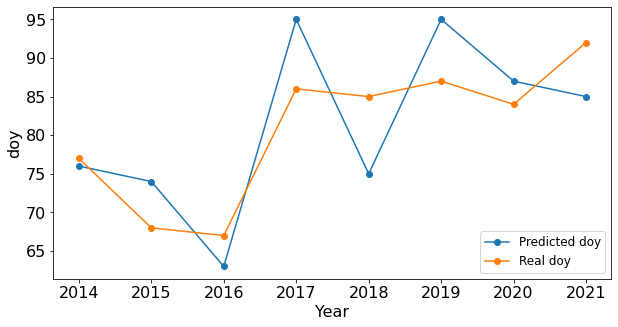

In [9]:
# plot the predict, real doy vs. year
start = 2014
end = 2021
result_pred_ts = predict_blooming_beta(start, end)
x = np.arange(start, end + 1)

f = plt.figure(figsize=(10, 5))
plt.plot(x, result_pred_ts, 'o-', label = 'Predicted doy')
plt.plot(x, seattle_doy, 'o-', label = 'Real doy')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
# plt.ylim([67, 115])
plt.xticks(np.arange(2014, 2022), fontsize = 16)
plt.yticks(fontsize = 16)
# plt.title("th = 0.5")
plt.legend(fontsize = 12, loc = 'lower right')
plt.show()
# f.savefig("../result_figures/washington_beta.png", bbox_inches='tight', dpi=1200)
# f.savefig("../result_figures/washington_beta_modified.png", bbox_inches='tight', dpi=1200)

In [10]:
np.array([np.average(train[train['year'] == y-1][-71:]['TAVG']) for y in range(2014, 2022)])

array([4.77056338, 6.16887324, 5.85633803, 5.79042254, 5.26929577,
       6.74619718, 5.79605634, 5.98591549])

## add prediction data

In [11]:
prediction_ds = pd.read_csv('Vancouver_temp_forecast_10_years.csv')
prediction_ds['doy'] = pd.to_datetime(prediction_ds['date']).dt.dayofyear
prediction_ds['year'] = pd.to_datetime(prediction_ds['date']).dt.year
prediction_ds['CDD'] = (prediction_ds.groupby(['year']))['temp'].cumsum()
prediction_ds.head()

,Unnamed: 0,temp,date,doy,year,CDD
0,1.0,-4.20,1/1/22,1,2022,-4.20
1,2.0,2.75,1/2/22,2,2022,-1.45
2,3.0,3.50,1/3/22,3,2022,2.05
3,4.0,2.55,1/4/22,4,2022,4.60
4,5.0,-1.29,1/5/22,5,2022,3.31


In [12]:
beta0_model = AutoReg(beta0_before, lags = 9, trend='c').fit()
beta1_model = AutoReg(beta1_before, lags = 3, trend='c').fit()
beta2_model = AutoReg(beta2_before, lags = 13, trend='c').fit()
# predict the blooming doy
# return the predicted doy
def predict_blooming_beta_ts(start, end):
    
    training_start = 1937
    
    predict = np.zeros(end - start + 1)
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the predict doy array
        if year >= start + 1:
            CU = np.average(prediction_ds[prediction_ds['year'] == year - 1][-71:]['temp'])
        else:
            CU = np.average(train[train['year'] == year - 1][-71:]['TAVG'])
        
        pre_year = prediction_ds[prediction_ds['year'] == year][:180]
        features = ['doy', 'CDD']
        X = pre_year[features]
        
        # predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
#         b0 = np.array([beta0_pre[year - start]])
        if CU < 5:
            b0 = np.array([beta0_pre[year - start] + 90])
#         elif CU > 6:
#             b0 = np.array([beta0 + 40])
        else:
            b0 = np.array([beta0_pre[year - start] + 20])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict


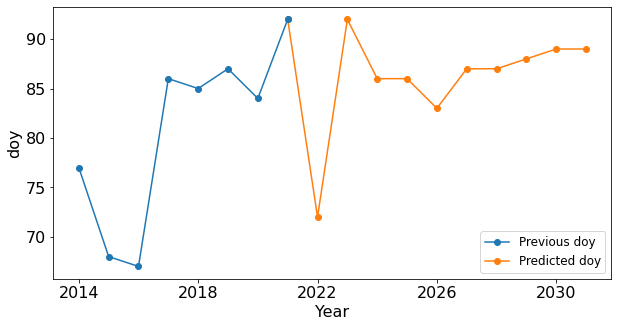

In [13]:
# plot the predict, real doy vs. year
start = 2022
end = 2031
result_pred_ts = predict_blooming_beta_ts(start, end)
x_r = seattle_year
x_p = np.arange(start, end + 1)

f = plt.figure(figsize=(10, 5))
plt.plot(x_r, seattle_doy, 'o-', label = 'Previous doy')
# plt.plot(x_p, result_pred_ts, 'o-', label = 'Predicted doy')
plt.plot(np.arange(start - 1, end + 1), np.insert(result_pred_ts, 
                                    0, seattle_doy[-1]), 'o-', label = 'Predicted doy', zorder = 1)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
plt.xticks(np.arange(2014, 2033, 4), fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 12, loc = 'lower right')
plt.show()
# f.savefig("../result_figures/vancouver_prediction.png", bbox_inches='tight', dpi=1200)

In [14]:
print(result_pred_ts)

[72. 92. 86. 86. 83. 87. 87. 88. 89. 89.]
